In [6]:
'''
Imports
'''
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

# Data loading and preprocessing

## As first thing, we load the csv files

In [10]:
import ast
import os
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [11]:
'''
Constants and file paths
'''
path = "dataset/fma_metadata/"
tracks_file = "tracks.csv"
genres_file = "genres.csv"
echonest_file = "echonest.csv"
features_file = "features.csv"

In [12]:
ds_tracks = load(path+tracks_file)
ds_genres = load(path+genres_file)
ds_features = load(path+features_file)
ds_echonest = load(path+echonest_file)

((2000, 2), (2000,))

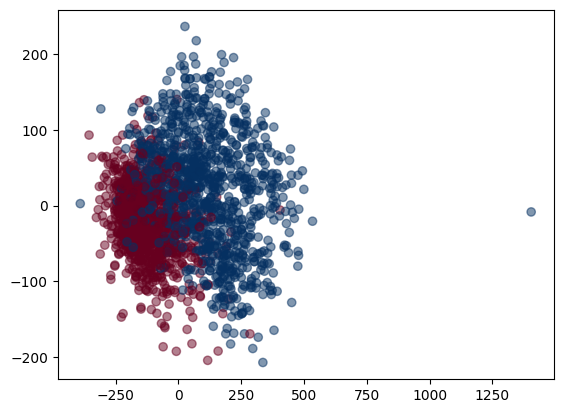

In [13]:
small = ds_tracks['set', 'subset'] <= 'small'
genre1 = ds_tracks['track', 'genre_top'] == 'Instrumental'
genre2 = ds_tracks['track', 'genre_top'] == 'Hip-Hop'

X = ds_features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = ds_tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

In [22]:
'''
Since we are dealing with the `medium` set, we extract it from the whole dataset
'''
#medium = ds_tracks[ds_tracks['set', 'subset'] <= 'medium']
#medium.shape

medium = ds_tracks['set', 'subset'] <= 'small'

train = ds_tracks['set', 'split'] == 'training'
val = ds_tracks['set', 'split'] == 'validation'
test = ds_tracks['set', 'split'] == 'test'

y_train = ds_tracks.loc[medium & train, ('track', 'genre_top')]
y_test = ds_tracks.loc[medium & test, ('track', 'genre_top')]
X_train = ds_features.loc[medium & train, 'mfcc']
X_test = ds_features.loc[medium & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [23]:
'''
The actual classification
'''
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
svm_clf = skl.svm.SVC()
svm_clf.fit(X_train, y_train)
score = svm_clf.score(X_test, y_test)
print('SVM stats:')
print('    Accuracy: {:.2%}'.format(score))

SVM stats:
    Accuracy: 46.38%


In [24]:
'''
Classification using kNN
'''
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=200) # number got by the paper

# cross_validate
cv_scores = cross_val_score(knn, X_train, y_train, cv=10)
knn.fit(X_train, y_train)

cv_scores_mean = np.mean(cv_scores)
print(cv_scores , "\n\n""mean =" ,"{:.2f}".format(cv_scores_mean))

predictions = knn.predict(X_test)

accuracy_score = knn.score(X_test, y_test) 
print("Accuracy score = ""{:.2f}".format(accuracy_score))

[0.4125    0.4390625 0.41875   0.44375   0.4234375 0.4390625 0.4640625
 0.4078125 0.43125   0.465625 ] 

mean = 0.43
Accuracy score = 0.37
